# Cloning quasars

Let's look at the redshift distributions of the quasars in the Sloan Digital Sky Survey.
The Sloan Digital Sky Survey or SDSS is a major multi-spectral imaging and spectroscopic redshift survey using a dedicated 2.5-m wide-angle optical telescope at Apache Point Observatory in New Mexico, United States. Operations started in 1998.

In phase 1, SDSS has released photometry data 357 million (!!!) unique sources and 1.6 million spectra. In phase 2, SDSS observed the same patch of the sky many times ("time domain astronomy", and now we're going to have LSST!)

<img src="https://classic.sdss.org/includes/sideimages/sdss_pie2.jpg" width="400">

In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
import astropy
from scipy import stats, interpolate

In [2]:
from astropy.visualization import hist
from astroML.density_estimation import EmpiricalDistribution

In [3]:
# Download the SDSS quasara data
from astroML.datasets import fetch_dr7_quasar

data = fetch_dr7_quasar()

data = data[:10000]

z = data['redshift']

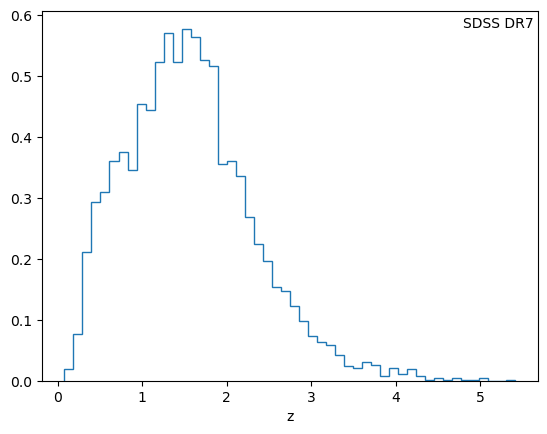

In [7]:
plt.hist(z,bins=50,histtype='step',density=True,label='original data')
plt.xlabel('z')
plt.text(4.8,0.58,'SDSS DR7')
plt.show()

- Upsample this distribution in two ways, using both rejection sampling and inverse transform.
- Check, at least visually, that the two cloned distribitions are indeed similar to the observed one (for a quantitative check, come back to this point in a few lectures)

(Hint: `scipy.stats` is your best friend)


### Cloning by Rejection Sampling

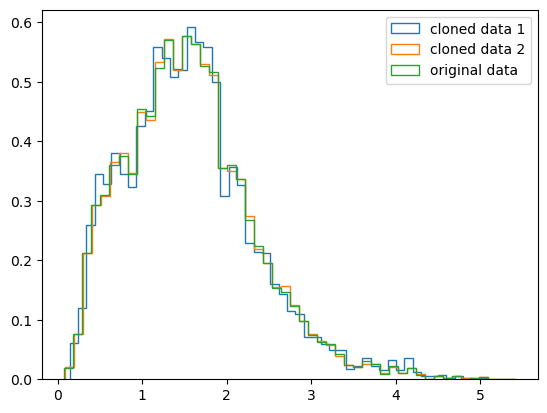

In [32]:
counts, bins = np.histogram(z, bins=100,density=True)
maxh = counts.max() # find the maximum

disth = stats.rv_histogram((counts,bins))
# It takes the counts (heights) and bins (edges) and creates an object (disth) that allows you
# to sample from a distribution that follows the shape of the original histogram.
# This object can now be treated like any other probability distribution, from which you can 
# draw random samples or evaluate the PDF (probability density function).

# Manual Monte Carlo Sampling from the Histogram
N = 100000 # trials
q = np.random.uniform(-10, 30, N) # proposed points
u = np.random.uniform(0, maxh, N) # uniform draws
mask = u<=disth.pdf(q) # assess whether u <= q(x_i)
monte_carlo = q[mask] # reject all points that don't pass, using masking

# using manual monte carlo:
plt.hist(monte_carlo, bins=50, density=True,histtype='step',label='cloned data 1');

# using disth directly: 
plt.hist(disth.rvs(size=N),bins=50,density=True,histtype='step',label='cloned data 2');

# original data
plt.hist(z,bins=50,histtype='step',density=True,label='original data')

plt.legend();



### Cloning by Inverse Transform

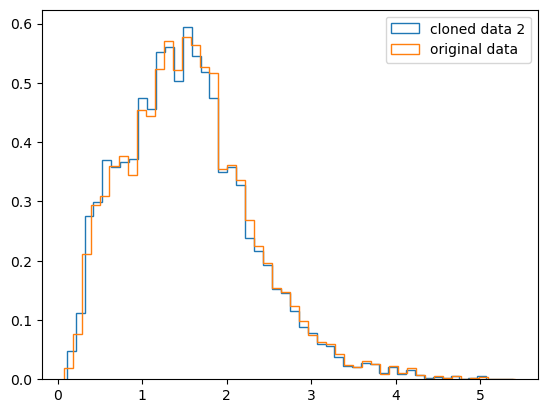

In [33]:
counts, bins = np.histogram(z, bins=100,density=True)
bin_mids = (bins[1:] + bins[:-1]) / 2 # mid location of bins

#integral approximated by a cumulative sum

cdf = np.cumsum(counts) / np.sum(counts) # very simply cumulative sum

inverse_of_cdf_fun = interpolate.interp1d(cdf,bin_mids)

# sampling
N = 100000 # trials
u = np.random.uniform(min(cdf),max(cdf), N)  # random.uniform(0,1) give interpolation range error. Why?

x = inverse_of_cdf_fun(u)


# cloned distribution: 
plt.hist(x,bins=50,density=True,histtype='step',label='cloned data 2')

# original data
plt.hist(z,bins=50,histtype='step',density=True,label='original data')

plt.legend()
plt.show()

# Cosmology

- Think about the cosmology of quasars. How do you think they are distributed? Overplot the theorethical distribution to the measured SDSS data. Does that agree with your expectation? 

(Hint: It shouldn't. But why?) 

(Hint: `astropy.cosmology` is another close friend). The best-fit cosmological model from the Plack data is:

**Comoving Volume in a Given Redshift**

Assuming a flat ΛCDM cosmology characterized by the Hubble constant $H_0$, matter density parameter $\Omega_m$, and dark energy density parameter $\Omega_\Lambda$, the comoving volume enclosed within a redshift $z$ is:
$$
V_c(z) = \frac{4\pi}{3} \, D_C^3(z)
$$
where $D_C(z)$ is the comoving distance to redshift $z$, defined as:
$$
D_C(z) = c \int_0^z \frac{dz'}{H(z')}
$$
(the coordinate distance between two points in the universe if we "freeze" the expansion. It is constant in time for objects moving with the Hubble flow) 

The Hubble parameter $H(z)$ is given by:
$$
H(z) = H_0 \sqrt{ \Omega_m (1+z)^3 + \Omega_\Lambda }
$$

If one is interested in the volume over a limited region of the sky (not full-sky), the volume scales with the solid angle $\Omega$:
$$
V_{\text{partial}} = V_c(z) \times \frac{\Omega}{4\pi}
$$
where $\Omega$ is in steradians. For a survey area $A$ in square degrees:
$$
\Omega = A \times \left( \frac{\pi}{180} \right)^2
$$

### Flux-limited selection (Malmquist bias)

In an expanding universe, more distant objects appear dimmer not only due to distance but also due to cosmological redshifting and time dilation. Correct for this using the luminosity distance $D_L(z)$ (defined in terms of the relationship between the absolute luminosity $L$ and apparent flux $F$ of an astronomical object):
$$
F= \frac{L}{4\pi D_L​(z)^2}​
$$
For a flux limit $F_\text{lim}$​, only objects with intrinsic luminosity
$$
L > 4\pi D_L(z)^2 F_\text{lim}
$$
are detectable. Assuming quasars have the same luminosity distribution $\tfrac{dN}{dL}$ independent on redshift, the number of quasars observable at redshift $z$ is:
$$
\frac{dN}{dz}(z) = \int_{L_{min}(z)}^\infty \frac{dN}{dz\,dL}{dL}
$$




In [10]:
astropy.cosmology.Planck18

FlatLambdaCDM(name="Planck18", H0=67.66 km / (Mpc s), Om0=0.30966, Tcmb0=2.7255 K, Neff=3.046, m_nu=[0.   0.   0.06] eV, Ob0=0.04897)

In [12]:
astropy.cosmology.FlatLambdaCDM(H0=70, Om0=0.3)

FlatLambdaCDM(H0=70.0 km / (Mpc s), Om0=0.3, Tcmb0=0.0 K, Neff=3.04, m_nu=None, Ob0=None)

Comoving volume out to z=2: 5.308e+03 Mpc


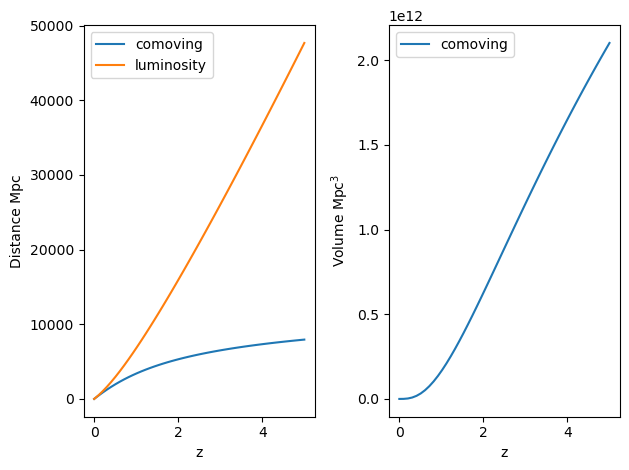

In [19]:
from astropy import cosmology

fig, ax = plt.subplots(1,2)

# Define redshift
z = np.linspace(0,5)

# Compute comoving distance and volume and luminosity distance out to redshift z
comoving_distance = cosmology.Planck18.comoving_distance(z)
comoving_volume = cosmology.Planck18.comoving_volume(z)
d_L = cosmology.Planck18.luminosity_distance(z)

ax[0].plot(z,comoving_distance,label='comoving')
ax[0].plot(z,d_L,label='luminosity')
ax[1].plot(z,comoving_volume,label='comoving')


ax[0].set(xlabel='z',ylabel='Distance Mpc')
ax[1].set(xlabel='z',ylabel='Volume Mpc$^3$')
ax[0].legend()
ax[1].legend()

print(f"Comoving volume out to z={2}: {cosmology.Planck18.comoving_distance(2):.3e}")

d_L = cosmology.Planck18.luminosity_distance(z)
#print(f"Luminosity distance at z={z}: {d_L:.2f}")

plt.tight_layout()

In [21]:
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

# Define your cosmology
cosmo = astropy.cosmology.Planck18

# Redshift
z = np.linspace(0,5)

# Comoving volume in Mpc^3
Vc = cosmo.comoving_volume(z)
d_L = cosmo.luminosity_distance(z)
#print(np.diff(Vc))
#print(d_L)

# normalization factor
# average number of quasars per Mpc^3
V_5 = cosmo.comoving_volume(5).value
N = len(data['redshift'])
normalization = N / V_5
print('average number of quasars per Mpc3 IN OUR DATA:', normalization)



average number of quasars per Mpc3 IN OUR DATA: 4.7579250980707654e-09


In [57]:
# Build the distribution of quasars
z = np.linspace(0,5)

Vc = cosmo.comoving_volume(z)
d_L = cosmo.luminosity_distance(z)


[3.25627120e+08 2.09154770e+09 5.13026742e+09 8.96839291e+09
 1.32209758e+10 1.75949976e+10 2.18813456e+10 2.59410011e+10
 2.96897270e+10 3.30838285e+10 3.61081824e+10 3.87668264e+10
 4.10759190e+10 4.30586786e+10 4.47418691e+10 4.61534462e+10
 4.73210402e+10 4.82710297e+10 4.90280199e+10 4.96145923e+10
 5.00512313e+10 5.03563614e+10 5.05464500e+10 5.06361464e+10
 5.06384374e+10 5.05648057e+10 5.04253844e+10 5.02291026e+10
 4.99838207e+10 4.96964526e+10 4.93730760e+10 4.90190320e+10
 4.86390122e+10 4.82371370e+10 4.78170241e+10 4.73818489e+10
 4.69343980e+10 4.64771158e+10 4.60121458e+10 4.55413660e+10
 4.50664213e+10 4.45887511e+10 4.41096132e+10 4.36301058e+10
 4.31511862e+10 4.26736871e+10 4.21983315e+10 4.17257454e+10
 4.12564690e+10] Mpc3
[    0.           470.33612077  1002.4492976   1589.35516233
  2224.62589113  2902.49112491  3617.8662548   4366.3299398
  5144.07126     5947.82240093  6774.7877171   7622.5757253
  8489.1374329   9372.7123422  10271.78224371 11185.03225834
 121

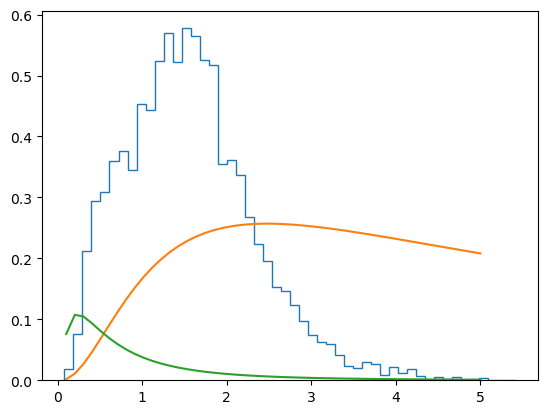

In [22]:
# shells of z = 0.1 volume

# original data
plt.hist(data['redshift'],bins=50,histtype='step',density=True,label='original data')

# with No selection bias
distribution = np.diff(Vc) * normalization 
plt.plot(z[1:],distribution/np.sum(distribution)*10)

# include selection bias
# assuming quasars have the same luminosity distribution at all redshifts

distribution = np.diff(Vc) / d_L[1:]**2
plt.plot(z[1:],distribution/np.sum(distribution))

